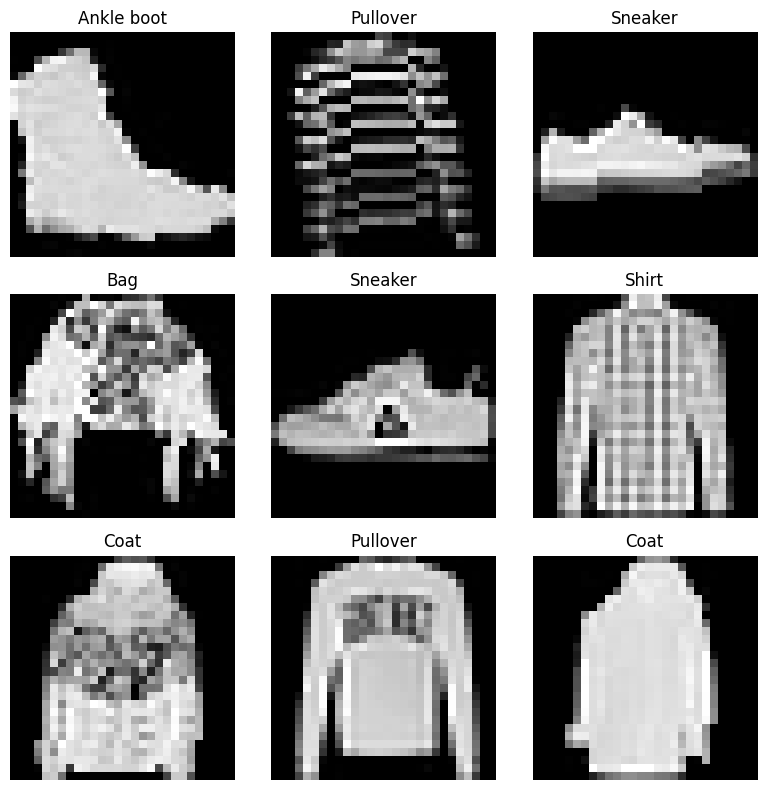

Train set size: 48000
Validation set size: 12000
Test set size: 10000


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for data preprocessing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),      # Small rotation
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize to range [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, transform=transform_train, download=True)

test_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, transform=transform_test, download=True)

# Split train dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define class names for visualization
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Function to visualize a batch of images
def imshow(images, labels):
    images = images.numpy()  # Convert from tensor to numpy
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()
    for img, ax, label in zip(images, axes, labels):
        img = img.squeeze()  # Remove channel dimension
        ax.imshow(img, cmap="gray")
        ax.set_title(class_names[label])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Display a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)
imshow(images[:9], labels[:9])

# Print dataset sizes
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define a simple CNN for Fashion MNIST (grayscale images: 1 x 28 x 28)
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 32 x 14 x 14
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2)                              # 64 x 7 x 7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model, loss function, optimizer, and scheduler
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training parameters
num_epochs = 20
patience = 5  # Early stopping patience
best_val_loss = np.inf
epochs_no_improve = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    train_loss /= total_train
    train_acc = correct_train / total_train

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()
    val_loss /= total_val
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Update learning rate scheduler based on validation loss
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_wts = model.state_dict()  # Save best model weights
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# Load best model weights
model.load_state_dict(best_model_wts)

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []
test_loss = 0.0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total_test += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
test_loss /= total_test
test_acc = np.mean(np.array(all_preds) == np.array(all_labels))

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Generate detailed classification report and confusion matrix
print("\nClassification Report:")
# 'class_names' should be defined as in part 1:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(classification_report(all_labels, all_preds, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Save the trained model
torch.save(model.state_dict(), "fashion_mnist_cnn.pth")
print("Model saved as fashion_mnist_cnn.pth")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20: Train Loss: 0.5032, Train Acc: 0.8179 | Val Loss: 0.3706, Val Acc: 0.8649
Epoch 2/20: Train Loss: 0.3379, Train Acc: 0.8758 | Val Loss: 0.3150, Val Acc: 0.8859
Epoch 3/20: Train Loss: 0.2915, Train Acc: 0.8926 | Val Loss: 0.3011, Val Acc: 0.8896
Epoch 4/20: Train Loss: 0.2624, Train Acc: 0.9028 | Val Loss: 0.2836, Val Acc: 0.8992
Epoch 5/20: Train Loss: 0.2432, Train Acc: 0.9090 | Val Loss: 0.2675, Val Acc: 0.9038
Epoch 6/20: Train Loss: 0.2280, Train Acc: 0.9152 | Val Loss: 0.2479, Val Acc: 0.9103
Epoch 7/20: Train Loss: 0.2143, Train Acc: 0.9191 | Val Loss: 0.2529, Val Acc: 0.9103
Epoch 8/20: Train Loss: 0.2044, Train Acc: 0.9246 | Val Loss: 0.2516, Val Acc: 0.9104
Epoch 9/20: Train Loss: 0.1932, Train Acc: 0.9287 | Val Loss: 0.2420, Val Acc: 0.9170
Epoch 10/20: Train Loss: 0.1868, Train Acc: 0.9300 | Val Loss: 0.2485, Val Acc: 0.9130
Epoch 11/20: Train Loss: 0.1810, Train Acc: 0.9324 | Val Loss: 0.2394, Val Acc: 0.9176
Epoch 12/20: Train Loss: 0.1750, Train Acc: 0.9347 |

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np

# Assume train_loader, val_loader, and test_loader are defined (from Part 1)
# and 'device' is set (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 1. Modify ResNet18 for Fashion MNIST:
#    - Change the first convolution layer to accept 1 channel instead of 3.
#    - Change the final fully connected layer to output 10 classes.
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

# 2. Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
num_epochs = 20  # Maximum epochs

# 3. Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader.dataset)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f} | Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "/best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# 4. Testing the Best Model
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = np.mean(np.array(test_preds) == np.array(test_labels))
test_precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
test_conf_matrix = confusion_matrix(test_labels, test_preds)

print("Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Confusion Matrix:\n{test_conf_matrix}")


Epoch 1/20
Train Loss: 0.5552, Val Loss: 0.4040 | Accuracy: 0.8503, Precision: 0.8536, Recall: 0.8506
Epoch 2/20
Train Loss: 0.4022, Val Loss: 0.3690 | Accuracy: 0.8652, Precision: 0.8713, Recall: 0.8651
Epoch 3/20
Train Loss: 0.3592, Val Loss: 0.3455 | Accuracy: 0.8728, Precision: 0.8760, Recall: 0.8731
Epoch 4/20
Train Loss: 0.3325, Val Loss: 0.3484 | Accuracy: 0.8615, Precision: 0.8749, Recall: 0.8612
Epoch 5/20
Train Loss: 0.3181, Val Loss: 0.3004 | Accuracy: 0.8882, Precision: 0.8891, Recall: 0.8885
Epoch 6/20
Train Loss: 0.3005, Val Loss: 0.3008 | Accuracy: 0.8928, Precision: 0.8938, Recall: 0.8929
Epoch 7/20
Train Loss: 0.2760, Val Loss: 0.2839 | Accuracy: 0.8977, Precision: 0.8972, Recall: 0.8982
Epoch 8/20
Train Loss: 0.2652, Val Loss: 0.2891 | Accuracy: 0.8927, Precision: 0.8943, Recall: 0.8930
Epoch 9/20
Train Loss: 0.2549, Val Loss: 0.2757 | Accuracy: 0.8993, Precision: 0.9007, Recall: 0.8997
Epoch 10/20
Train Loss: 0.2424, Val Loss: 0.2733 | Accuracy: 0.9022, Precision: 0.